<h1 style="font-size:2.5em; color:#f5a442;">Machine Learning [4483] Project: A second
hand car price prediction
system with additional trends and
insights</h1>

<h2 style="font-size:1.5em; color:#808080;">Kai Broux (r0745431) and Luigi Guerriero (r0760424)</h2>
<h2 style="font-size:1.0em; color:#808080;">Master's students IIW UHasselt-KULeuven Campus Diepenbeek</h2>

# 1. Introduction

The goal of our project is to make a price prediction system for used cars and to extract interesting information and insights. The price prediction model and insights can be extracted from a dataset of different used cars. The model and insights could be then later used as a tool for a second-hand car retailer to give insights to potential customers shopping for a second-hand car. Moreover, this price prediction model and insights tool may also come in handy for a customer looking to sell his/her car.

This [`dataset`](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) contains data from 100 000 used cars from the UK which are divided into separate brands. Each brand is divided into a separate file and contains information about the model, year, price, transmission, mileage, fuel type, road tax, mpg and engine size.

Before we begin with the project, we need to import all libraries required for this project. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# used for importing .csv data
import pandas as pd

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# Optimization module in scipy
from scipy import optimize

# For determining R2
from sklearn.metrics import r2_score

# Tools for extracting how much features and which features we need
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

import scipy

import seaborn as sbn

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# 2. Project itself

###  2.1 Loading in the data

As mentioned in the introduction a separate file of a car brand is stored in a `.csv` file and consist of the following columns:

    Model: Model type.
    Year: Registration Year.
    Price: Price in euros.
    Transmission: Type of Gearbos.
    Mileage: Distance Used.
    FuelType: Engine Fuel.
    Tax: Road Tax.
    mpg: Miles per Gallon.
    EngineSize: Size in litres.
    Brand: Name of the car brand.

To load in the dataset, we first have to load in the separate `.csv` files. 

In [2]:
audi = pd.read_csv("dataset/audi.csv")
bmw = pd.read_csv("dataset/bmw.csv")
ford = pd.read_csv("dataset/ford.csv")
hyundai = pd.read_csv("dataset/hyundi.csv")
mercedes = pd.read_csv("dataset/merc.csv")
skoda = pd.read_csv("dataset/skoda.csv")
toyota = pd.read_csv("dataset/toyota.csv")
vauxhall = pd.read_csv("dataset/vauxhall.csv")
volkswagen = pd.read_csv("dataset/vw.csv")

We are having different datasets for different brands. So if we want to combine them we need to add an extra column to each `.csv` file describing the name of the brand :

In [3]:
audi['brand'] = 'audi'
bmw['brand'] = 'bmw'
ford['brand'] = 'ford'
hyundai['brand'] = 'hyundai'
mercedes['brand'] = 'mercedes'
skoda['brand'] = 'skoda'
toyota['brand'] = 'toyota'
vauxhall['brand'] = 'vauxhall'
volkswagen['brand'] = 'volkswagen'

### 2.2 Lineair regression with one variable 

To start of simply, we are going to apply linear regression with one variable to determine the price of a Mercedes C-class, more specific the W205 model. We can use the `cclass.csv` and only look to at the the C-class from years 2014-2021.

We have to first load the dataset:

In [4]:
cclass = pd.read_csv("dataset/cclass.csv")
display(cclass)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


Let's take a look at our price density to figure out if we have to trim the data:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

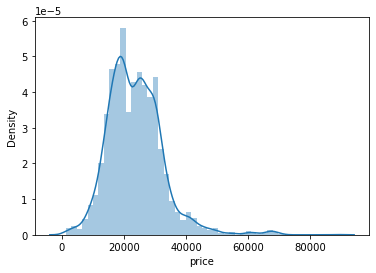

In [5]:
sbn.distplot(cclass["price"])

There are a lot of outliers above the 50000 price that do not respresent the majority of the data. So we filter out the c-classes ranging from 0-50000:

Since we want to examine the C-class W205 model we have to filter out the C-classes that are not in the 2014-2021 year-range: 

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3891,C Class,2018,23600,Automatic,18834,Petrol,2.0
3892,C Class,2018,19900,Manual,31540,Petrol,2.0
3893,C Class,2016,21000,Automatic,21547,Diesel,2.1
3894,C Class,2017,14700,Manual,31357,Diesel,1.6


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

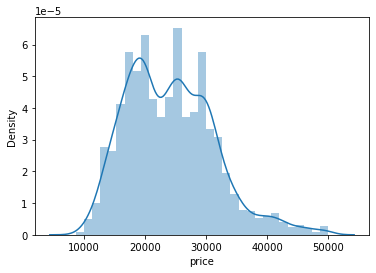

In [6]:
cclass = cclass.loc[(cclass['price'] >= 0) & (cclass['price'] <= 50000)]
cclass = cclass[(cclass['year'] > 2014) & (cclass['year'] < 2022)]
display(cclass)

sbn.distplot(cclass["price"])

For the lineair regression with one variable, we will choose the mileage as variable (for the x-axis). The price will be selected for the y-axis. We will then visualise the data. Let's take a look at the graph we're working with:

Text(0.5, 0, 'Mileage in miles')

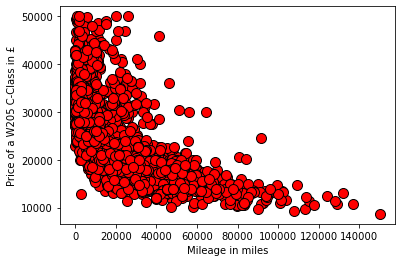

In [7]:
#X and y values of the entire dataset (for visualisation)
X_all = cclass['mileage'].to_numpy()
y_all = cclass['price'].to_numpy()
m_all = y_all.size #dataset size

#Visualise data
fig = pyplot.figure()  # open a new figure    
pyplot.plot(X_all, y_all, 'ro', ms=10, mec='k')
pyplot.ylabel('Price of a W205 C-Class in £')
pyplot.xlabel('Mileage in miles')

#### Splitting Data into CV, training and test set (after shuffling the data)

In [8]:
cclass_shuffled = cclass.sample(frac=1)
cclass_shuffled.head()

,model,year,price,transmission,mileage,fuelType,engineSize
209,C Class,2019,28990,Semi-Auto,2000,Diesel,2.0
2823,C Class,2016,20192,Automatic,34000,Diesel,2.1
2289,C Class,2019,30499,Semi-Auto,1126,Diesel,2.0
1635,C Class,2019,38521,Automatic,50,Diesel,2.0
2060,C Class,2019,41949,Semi-Auto,8315,Petrol,3.0


In [9]:
zero_60percent= int(len(cclass_shuffled)*0.6) 
sixty_80percent = int(len(cclass_shuffled)*0.8) 
hundred_percent = int(len(cclass_shuffled))

cclass_train = cclass_shuffled.iloc[0:zero_60percent]  #0-60%
cclass_CV = cclass_shuffled.iloc[zero_60percent:sixty_80percent] #20%: 60-80
cclass_test = cclass_shuffled.iloc[sixty_80percent:hundred_percent] #20%: 80-100

print(len(cclass_train),len(cclass_CV),len(cclass_test))

2137 713 713


Load the data into X and Y

In [10]:
# training data
X = cclass_train['mileage'].to_numpy()
y = cclass_train['price'].to_numpy()
m = y.size #dataset size

# cross validation data
X_CV = cclass_CV['mileage'].to_numpy()
y_CV = cclass_CV['price'].to_numpy()
m_CV = y_CV.size

# test data
X_test = cclass_test['mileage'].to_numpy()
y_test = cclass_test['price'].to_numpy()
m_test = y_test.size

#### Gradient descent  

In this part, we will fit the linear regression parameters $\theta$ to our dataset using gradient descent.

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

The parameters of our model are the $\theta_j$ values. These are
the values we will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, our parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

We first want to normalize our features of the training data to make sure our gradient descent works out without any overflow problems. Besides the normalization, we add a column of ones to X:

In [11]:
mu = np.mean(X, axis = 0)
sigma = np.std(X, axis = 0)
X_norm = (X - mu) / sigma

In [12]:
X_not_norm = X  #save original X if we need it later
X_not_norm_stacked = np.stack([np.ones(m), X_not_norm], axis=1)  #column of ones to the original X
X  = np.stack([np.ones(m), X_norm], axis=1)                      #column of ones to the normalized X

For the cost function we can define a function that determines the cost:

In [13]:
def computeCost(X, y, theta):
    m = y.size  # number of training examples
    
    J = 0 # initializing the cost
    
    h = np.dot(X, theta)
    inner = (h-y)**2
    J = (1/(2*m)) * (np.sum(inner))

    return J

For Gradient descent we can define following function:

In [14]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = y.shape[0] # number of training examples
    
    # a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # python list to save cost in every iteration
    
    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history

We initialize the 𝜃 parameters to 0 and the learning rate 𝛼 to 0.01 and use the final parameters to plot the lineair fit:

In [15]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 100000
alpha = 0.01

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))

Theta found by gradient descent: 24204.2948, -4911.1687


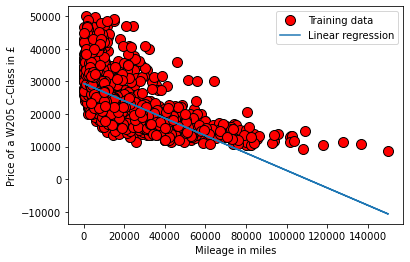

In [16]:
# plot the linear fit
fig = pyplot.figure()  # open a new figure    
pyplot.plot(X_not_norm_stacked[:, 1], y, 'ro', ms=10, mec='k')
pyplot.ylabel('Price of a W205 C-Class in £')
pyplot.xlabel('Mileage in miles')
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

## Regularised linear regression

A cost function and a gradient descent function for linear regresssion, but with regularization parameter alhpa.

In [17]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    m = y.size # number of training examples

    J = 0 # initializing the cost
    grad = np.zeros(theta.shape) # initiliazing the gradient descent
    
    h= np.dot(X, theta)   
    J = (1/(2*m)) * (np.sum((h-y)**2)) + (lambda_/(2*m))*(np.sum(theta[1:]**2))  
    
    grad = (1 / m) * (h - y).dot(X)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]

    return J, grad

A function to determine the optimal theta.

In [18]:
def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    # Initializing Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

#### Selecting $\lambda$ using a cross validation set

In [19]:
def validationCurve(X, y, Xval, yval):
    # Selected values of lambda
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # initializing the training- and the cross-validation error
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    
    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t = trainLinearReg(linearRegCostFunction, X, y, lambda_ = lambda_try)
        error_train[i], _ = linearRegCostFunction(X, y, theta_t, lambda_ = 0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_ = 0)

    return lambda_vec, error_train, error_val

Since we haven't normalized our features from our cross validation set, we have to do it first before proceeding:

In [20]:
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)
mu_CV = np.mean(X_CV, axis = 0)
sigma_CV = np.std(X_CV, axis = 0)
X_CV_norm = (X_CV - mu_CV) / sigma_CV
X_CV_norm_stacked  = np.concatenate([np.ones((m_CV,1)), X_CV_norm], axis=1)

# original X_CV stacking with a row of ones (for later).
X_CV_with_ones = np.concatenate([np.ones((m_CV,1)), X_CV], axis=1)

Now, we can calculate the optimal lambda to use for our model.

lambda		Train Error	Validation Error
 0.000000	14011532.823504	15958925.849306
 0.001000	14011532.823506	15958926.298881
 0.003000	14011532.823528	15958927.198046
 0.010000	14011532.823768	15958930.345274
 0.030000	14011532.825880	15958939.338667
 0.100000	14011532.849909	15958970.830849
 0.300000	14011533.061106	15959060.939705
 1.000000	14011535.461804	15959377.849743
 3.000000	14011556.523850	15960296.376232
 10.000000	14011794.447938	15963662.272291


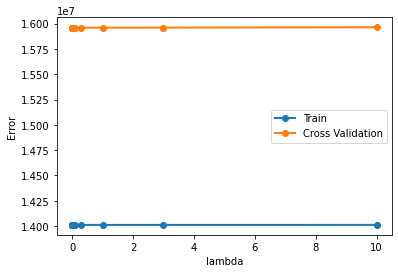

In [21]:
lambda_vec, error_train, error_val = validationCurve(X, y, X_CV_norm_stacked, y_CV)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

Since all the lambda's have almost exactly the same train- and corss- validation error, we will stick to $\lambda$ = 0.

#### Regularised linear regression with our chosen $\lambda$ 

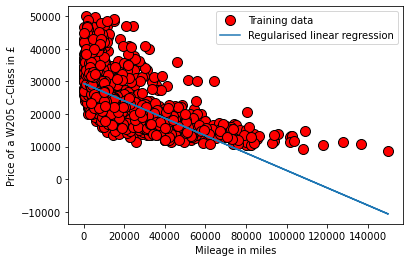

In [22]:
# calculate theta
theta_regularized = trainLinearReg(linearRegCostFunction, X, y, lambda_=0)

# plot the linear fit
fig = pyplot.figure()  # open a new figure    
pyplot.plot(X_not_norm_stacked[:, 1], y, 'ro', ms=10, mec='k')
pyplot.ylabel('Price of a W205 C-Class in £')
pyplot.xlabel('Mileage in miles')
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta_regularized), '-')
pyplot.legend(['Training data', 'Regularised linear regression']);

#### The final part of our linear regression model is to analyze it. We will do this by calculating the R²-score, a learning curve and an error histogram.

R²-score:

In [23]:
y_pred = np.dot(X, theta_regularized)
print("The R²-score of our linear regression model: ",r2_score(y, y_pred))

The R²-score of our linear regression model:  0.4625691417945752


Function to calculate the learning curve:

In [24]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    # Number of training examples
    m = y.size

    # initializing the training- and the cross-validation error
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    for i in range(1, m+1):
        theta_t = trainLinearReg(linearRegCostFunction, X[:i], y[:i], lambda_ = lambda_)
        error_train[i - 1], _ = linearRegCostFunction(X[:i], y[:i], theta_t, lambda_ = 0)
        error_val[i - 1], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_ = 0)

    return error_train, error_val

Plot the learning curve for our linear regression model:

[]

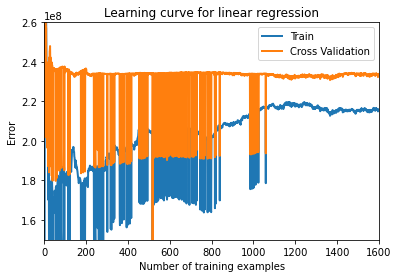

In [25]:
error_train, error_val = learningCurve(X_not_norm_stacked, y, X_CV_with_ones, y_CV, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1600, 150000000, 260000000])
pyplot.plot()


# Uncomment the code below if you want to see the exact error for each training example.

# print('# Training Examples\tTrain Error\tCross Validation Error')
# for i in range(m):
#     print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

Error histogram of the cross validation set:

(array([329., 208.,  99.,  33.,  15.,  13.,   9.,   5.,   0.,   2.]),
 array([9.84258009e+00, 2.73668668e+03, 5.46353078e+03, 8.19037488e+03,
        1.09172190e+04, 1.36440631e+04, 1.63709072e+04, 1.90977513e+04,
        2.18245954e+04, 2.45514395e+04, 2.72782836e+04]),
 <BarContainer object of 10 artists>)

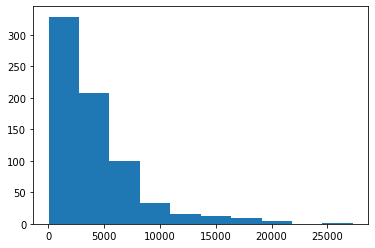

In [26]:
theta_regularized_CV = trainLinearReg(linearRegCostFunction, X_CV_norm_stacked, y_CV, lambda_=0)
y_pred_CV = np.dot(X_CV_norm_stacked, theta_regularized_CV)
error = np.abs(y_CV - y_pred_CV)

pyplot.hist(error)

The R²-score is noticeable small, the learning curve has a high value of the error and the error histogram has some high values as well. From this, we can conclude that linear regression is not the best fit for our dataset. We wil move on to Polynomial regression to see if we can get a better model.

## Polynomial regression

The problem with our linear model was that it was too simple for the data and because of that, it resulted in underfitting (high bias).

To start with our polynomial regression model, we will first implement a function that can make a feature into a polynomial function (with a degree).

In [27]:
def polyFeatures(X, p):
    X_poly = np.zeros((X.shape[0], p))

    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    return X_poly

We will also make a function that can plot this ploynomial function on a graph.

In [28]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)

Before we start calculating stuff, we are going to reload the data to make sure nothing goes wrong.

In [29]:
#Reload variables into X an Y

# training data
X = cclass_train['mileage'].to_numpy()
y = cclass_train['price'].to_numpy()
m = y.size #dataset size

# cross validation data
X_CV = cclass_CV['mileage'].to_numpy()
y_CV = cclass_CV['price'].to_numpy()
m_CV = y_CV.size

# test data
X_test = cclass_test['mileage'].to_numpy()
y_test = cclass_test['price'].to_numpy()
m_test = y_test.size

# reshaping X_CV into the right shape
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)

#### Selecting our polynomial degree

In [30]:
# Selected values of our degree (p)
p_vec = [1,2,3,4,5,6]

# initializing the train- and cross validation error.
error_train = np.zeros(len(p_vec))
error_val = np.zeros(len(p_vec))

for i in range(len(p_vec)):
    p_try = p_vec[i]

    # training
    X_not_norm_for_poly = np.array(X).reshape(np.array(X).size,1)
    X_not_norm_poly = polyFeatures(X_not_norm_for_poly, p_try)
    mu = np.mean(X_not_norm_poly, axis = 0)
    sigma = np.std(X_not_norm_poly, axis = 0)
    X_poly_norm = (X_not_norm_poly - mu) / sigma
    X_poly_norm_with_ones = np.concatenate([np.ones((m, 1)), X_poly_norm], axis=1)

    # CV
    X_poly_CV = polyFeatures(X_CV, p_try)
    mu_poly_CV = np.mean(X_poly_CV, axis = 0)
    sigma_poly_CV = np.std(X_poly_CV, axis = 0)
    X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
    X_poly_CV_norm_ones = np.concatenate([np.ones((m_CV, 1)), X_poly_CV_norm], axis=1) #concatenate ones


    theta_t = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y, lambda_ = 0, maxiter=100000)
    error_train[i], _ = linearRegCostFunction(X_poly_norm_with_ones, y, theta_t, lambda_ = 0)
    error_val[i], _ = linearRegCostFunction(X_poly_CV_norm_ones, y_CV, theta_t, lambda_ = 0)

Now, we can plot the degree (p) in function of the error to see wich value of p we should work further with.

p		Train Error	Validation Error
 1.000000	14011532.823504	15958925.849306
 2.000000	12034124.755207	13609042.450559
 3.000000	11485178.105812	13171884.371670
 4.000000	11484517.096461	13167804.509941
 5.000000	11484070.843899	13167665.520235
 6.000000	11465488.870924	13222099.498724


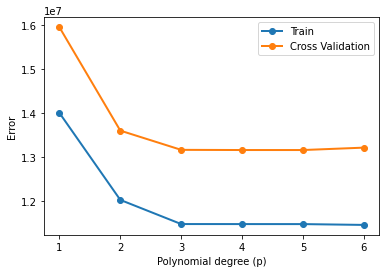

In [31]:
pyplot.plot(p_vec, error_train, '-o', p_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Polynomial degree (p)')
pyplot.ylabel('Error')

print('p\t\tTrain Error\tValidation Error')
for i in range(len(p_vec)):
    print(' %f\t%f\t%f' % (p_vec[i], error_train[i], error_val[i]))

From a degree of 3, the error no longer decreases. That is why we will use a degree of 3 (p=3).

In [32]:
p = 3

#### Selecting $\lambda$ using a cross validation set

We first need to normalize our features for the test, training and CV set for p=3.

In [41]:
X_not_norm_for_poly = np.array(X_not_norm).reshape(np.array(X_not_norm).size,1)
# Map X onto Polynomial Features 
X_not_norm_poly = polyFeatures(X_not_norm_for_poly, p)

# normalize training features
mu = np.mean(X_not_norm_poly, axis = 0)
sigma = np.std(X_not_norm_poly, axis = 0)
X_poly_norm = (X_not_norm_poly - mu) / sigma
X_poly_norm_with_ones = np.concatenate([np.ones((m, 1)), X_poly_norm], axis=1)

# do the same for cross validation features
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)
X_poly_CV = polyFeatures(X_CV, p)
mu_poly_CV = np.mean(X_poly_CV, axis = 0)
sigma_poly_CV = np.std(X_poly_CV, axis = 0)
X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
X_poly_CV_norm_ones = np.concatenate([np.ones((m_CV, 1)), X_poly_CV_norm], axis=1) #concatenate ones

# do the same for test features
X_test = np.array(X_test).reshape(np.array(X_test).size,1)
X_poly_test = polyFeatures(X_test, p)
mu_poly_test = np.mean(X_poly_test, axis = 0)
sigma_poly_test = np.std(X_poly_test, axis = 0)
X_poly_test_norm = (X_poly_test - mu_poly_test) / sigma_poly_test
X_poly_test_norm_ones = np.concatenate([np.ones((m_test, 1)), X_poly_test_norm], axis=1) #concatenate ones

Plotting lambda in function of the error to select an appropriate lambda.

lambda		Train Error	Validation Error
 0.000000	11485178.105812	13171884.371670
 0.001000	11485178.110024	13171897.937634
 0.003000	11485178.143715	13171925.084004
 0.010000	11485178.526631	13172020.247743
 0.030000	11485181.884834	13172293.439435
 0.100000	11485219.772471	13173264.534483
 0.300000	11485544.995804	13176162.519576
 1.000000	11488961.337796	13187583.732092
 3.000000	11513083.028812	13227904.534591
 10.000000	11660356.644885	13394466.403414


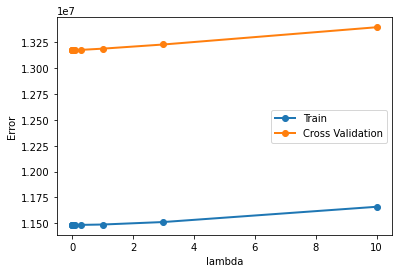

In [43]:
lambda_vec, error_train, error_val = validationCurve(X_poly_norm_with_ones, y, X_poly_CV_norm_ones, y_CV)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

The error is the lowest when lambda=0.

In [44]:
lambda_ = 0

#### Polynomial regression with our chosen $\lambda$ 

Plotting our polynomial regression model:

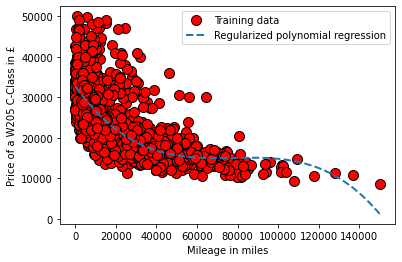

In [45]:
theta_poly = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y, lambda_=lambda_, maxiter=100000)

fig = pyplot.figure()  # open a new figure    
pyplot.plot(X_not_norm_stacked[:, 1], y, 'ro', ms=10, mec='k')
pyplot.ylabel('Price of a W205 C-Class in £')
pyplot.xlabel('Mileage in miles') 
plotFit(polyFeatures, np.min(X_not_norm_for_poly), np.max(X_not_norm_for_poly), mu, sigma, theta_poly, p)
pyplot.legend(['Training data', 'Regularized polynomial regression']);

#### The final part of our polynomial regression model is to analyze it. We will do this by calculating the R²-score, a learning curve and an error histogram.

Determining the R²-score:

In [47]:
y_pred_poly = np.dot(X_poly_norm_with_ones, theta_poly)

print("The R²-score for our polynomial regression model:",r2_score(y, y_pred_poly))

The R²-score for our polynomial regression model: 0.559470815663053


The learning curve:

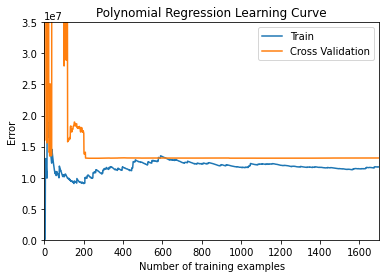

In [49]:
pyplot.figure()
error_train_poly, error_val_poly = learningCurve(X_poly_norm_with_ones, y, X_poly_CV_norm_ones, y_CV, lambda_ )
pyplot.plot(np.arange(1, 1+m), error_train_poly, np.arange(1, 1+m), error_val_poly)

pyplot.title('Polynomial Regression Learning Curve')
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1700, 0, 35000000])
pyplot.legend(['Train', 'Cross Validation'])


# Uncomment the code below if you want to see the exact error for each training example.

# print('# Training Examples\tTrain Error\tCross Validation Error')
# for i in range(m):
#     print('  \t%d\t\t%f\t%f' % (i+1, error_train_poly[i], error_val_poly[i]))

Error histogram of the cross validation set:

(array([419., 189.,  54.,  17.,  13.,  14.,   5.,   0.,   0.,   2.]),
 array([5.27707119e+00, 2.99007542e+03, 5.97487378e+03, 8.95967213e+03,
        1.19444705e+04, 1.49292688e+04, 1.79140672e+04, 2.08988655e+04,
        2.38836639e+04, 2.68684622e+04, 2.98532606e+04]),
 <BarContainer object of 10 artists>)

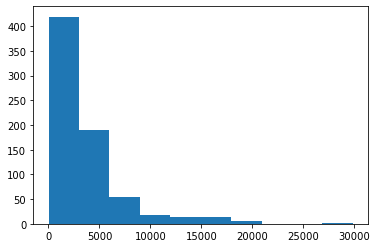

In [50]:
theta_poly_CV = trainLinearReg(linearRegCostFunction, X_poly_CV_norm_ones, y_CV, lambda_=lambda_, maxiter=100000)
y_poly_pred_CV = np.dot(X_poly_CV_norm_ones, theta_poly_CV)
fout_poly_CV = np.abs(y_CV - y_poly_pred_CV)
pyplot.hist(fout_poly_CV)

The R²-score is again noticeable small, but larger than the one we calculated for linear regression. The learning curve has still a high value of the error, but a smaller one than the linear regression. The error histogram has some high values again, but in general smaller than the linear regression. From this, we can conclude that polynomial regression is a bit better than linear regression, but still not the best fit for our dataset. We wil move on to multivariate linear regression to see if we can get a better model. For this model we will use the entire mercedes dataset.

Price prediction of a single example:

In [52]:
X_prediction = [1, 75000, 75000**2, 75000**3] #for a car with 75 000 miles
X_prediction[1:4] = (X_prediction[1:4] - mu) / sigma

price = np.dot(X_prediction, theta_poly)
print(price)

15062.792838701902


# Price prediction of specific brand: Mercedes

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

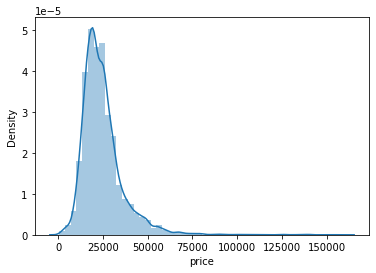

In [55]:
sbn.distplot(mercedes["price"])

Niet goed, we gaan proberen te filteren van 0-  60 000 :

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

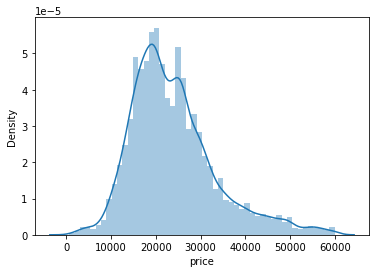

In [56]:
mercedes = mercedes.loc[(mercedes['price'] >= 0) & (mercedes['price'] <= 60000)]
sbn.distplot(mercedes["price"])

Data inladen en categorical variabelen fixen:

In [57]:
data_mercedes_expanded = pd.get_dummies(mercedes)
data_mercedes_expanded.drop('brand_mercedes', axis=1, inplace=True)
data_mercedes_expanded.head()

,year,price,mileage,tax,mpg,engineSize,model_ A Class,model_ B Class,model_ C Class,model_ CL Class,...,model_220,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2005,5200,63000,325,32.1,1.8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2017,34948,27000,20,61.4,2.1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2016,49948,6200,555,28.0,5.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,2018,30948,16000,145,47.9,2.1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7,2012,10948,107000,265,36.7,3.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Data normaliseren:

In [58]:
mercedes_expanded_numpy = data_mercedes_expanded.to_numpy()
print("Numpy dataset: \n",mercedes_expanded_numpy)
print("\nShape dataset: ",mercedes_expanded_numpy.shape)

mu_mercedes = np.mean(mercedes_expanded_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes = np.std(mercedes_expanded_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_numpy_norm = (mercedes_expanded_numpy - mu_mercedes) / sigma_mercedes
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_numpy_norm)

Numpy dataset: 
 [[2.0050e+03 5.2000e+03 6.3000e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.0170e+03 3.4948e+04 2.7000e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [2.0160e+03 4.9948e+04 6.2000e+03 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.0190e+03 3.0999e+04 1.1612e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 3.7990e+04 2.4260e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 5.4999e+04 2.0750e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

Shape dataset:  (12943, 41)

Normalized Mercedes dataset: 
 [[-5.5063881  -1.94899173  1.92461731 ... -0.1163932  -0.02326211
   1.61036689]
 [-0.12362107  1.14474363  0.22662574 ...  8.59156731 -0.02326211
  -0.6209765 ]
 [-0.57218499  2.70471507 -0.75443605 ... -0.1163932  -0.02326211
   1.61036689]
 ...
 [ 0.77350677  0.73405515 -0.49917132 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  1.46110583 -0.93244217 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  3.23000945 -0.94899759 ... -0.1163932  -0.02326211
  

Selecting how much features and which features to be selected:

In [59]:
column_names_mercedes = data_mercedes_expanded.drop(columns = ['price']).columns
print(column_names_mercedes)

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class',
       'model_ B Class', 'model_ C Class', 'model_ CL Class',
       'model_ CLA Class', 'model_ CLC Class', 'model_ CLK',
       'model_ CLS Class', 'model_ E Class', 'model_ G Class',
       'model_ GL Class', 'model_ GLA Class', 'model_ GLB Class',
       'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class',
       'model_ M Class', 'model_ R Class', 'model_ S Class', 'model_ SL CLASS',
       'model_ SLK', 'model_ V Class', 'model_ X-CLASS', 'model_180',
       'model_200', 'model_220', 'model_230', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'fuelType_Diesel', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')


(12943, 40)
(12943,)
(12943, 41)


Text(0.5, 0, 'number of features')

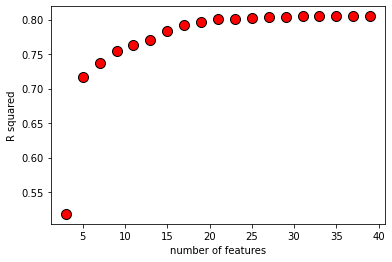

In [80]:
#data
X_mercedes = np.delete(mercedes_expanded_numpy_norm, 1, axis=1)
y_mercedes = mercedes_expanded_numpy_norm[:,1]
y_mercedes_not_norm = mercedes_expanded_numpy[:,1]
print(X_mercedes.shape)
print(y_mercedes.shape)
print(mercedes_expanded_numpy_norm.shape)


#for features
no_of_features = []
r_squared = []


for k in range(3, 40, 2):
    selector = SelectKBest(f_regression, k = k)
    X_transformed = selector.fit_transform(X_mercedes, y_mercedes)
    regressor = LinearRegression()
    regressor.fit(X_transformed, y_mercedes)
    no_of_features.append(k)
    teller = (1-(regressor.score(X_transformed, y_mercedes)))*(y_mercedes.size-1)
    noemer = y_mercedes.size-1
    r_squared.append(1-(teller/noemer))

fig = pyplot.figure()  # open a new figure    
pyplot.plot(no_of_features, r_squared, 'ro', ms=10, mec='k')
pyplot.ylabel('R squared')
pyplot.xlabel('number of features')   


In [61]:
selector = SelectKBest(f_regression, k = 20)
X_train_transformed = selector.fit_transform(X_mercedes, y_mercedes)
features_columns = column_names_mercedes[selector.get_support()]
print(features_columns.to_numpy().tolist())

['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Petrol']


In [62]:
data_mercedes_expanded_filtered = data_mercedes_expanded[features_columns.to_numpy().tolist()]
data_mercedes_expanded_filtered.head()

,year,mileage,tax,mpg,engineSize,model_ A Class,model_ B Class,model_ E Class,model_ GLA Class,model_ GLC Class,model_ GLE Class,model_ GLS Class,model_ S Class,model_ SL CLASS,model_ SLK,model_ V Class,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Petrol
0,2005,63000,325,32.1,1.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,2017,27000,20,61.4,2.1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2016,6200,555,28.0,5.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6,2018,16000,145,47.9,2.1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7,2012,107000,265,36.7,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Normalise features and convert to numpy:

In [63]:
mercedes_expanded_goodfeatures_numpy = data_mercedes_expanded_filtered.to_numpy()
print(mercedes_expanded_goodfeatures_numpy)

#normalize
mu_mercedes_features = np.mean(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes_features = np.std(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_features_norm = (mercedes_expanded_goodfeatures_numpy - mu_mercedes_features) / sigma_mercedes_features
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_features_norm)

[[2.0050e+03 6.3000e+04 3.2500e+02 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.0170e+03 2.7000e+04 2.0000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0160e+03 6.2000e+03 5.5500e+02 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.0190e+03 1.1612e+04 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.0190e+03 2.4260e+03 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.0190e+03 2.0750e+03 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

Normalized Mercedes dataset: 
 [[-5.5063881   1.92461731  2.99362037 ... -1.04270993 -1.55636222
   1.61036689]
 [-0.12362107  0.22662574 -1.67964527 ... -1.04270993 -1.55636222
  -0.6209765 ]
 [-0.57218499 -0.75443605  6.51772233 ... -1.04270993 -1.55636222
   1.61036689]
 ...
 [ 0.77350677 -0.49917132  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 0.77350677 -0.93244217  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 0.77350677 -0.94899759  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]]


Paste 1's before continueing:

In [64]:
m_merc = y_mercedes.size #dataset size
X_multi_not_norm = np.concatenate([np.ones((m_merc, 1)), mercedes_expanded_goodfeatures_numpy], axis=1)
X_multi_merc = np.concatenate([np.ones((m_merc, 1)), mercedes_expanded_features_norm], axis=1)
print(X_multi_merc)
#print(mercedes_expanded_features_norm.shape)
#print(m_merc)


[[ 1.         -5.5063881   1.92461731 ... -1.04270993 -1.55636222
   1.61036689]
 [ 1.         -0.12362107  0.22662574 ... -1.04270993 -1.55636222
  -0.6209765 ]
 [ 1.         -0.57218499 -0.75443605 ... -1.04270993 -1.55636222
   1.61036689]
 ...
 [ 1.          0.77350677 -0.49917132 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 1.          0.77350677 -0.93244217 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 1.          0.77350677 -0.94899759 ... -1.04270993  0.64252395
  -0.6209765 ]]


Some functions to compute cost and gradient descent for multiple features:

In [65]:
def computeCostMulti(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # You need to return the following variable correctly
    J = 0
    
    # ======================= YOUR CODE HERE ===========================
    h = np.dot(X, theta)
    
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    # ==================================================================
    return J

def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        # ======================= YOUR CODE HERE ==========================

        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        # =================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history


In [81]:
"""
# initialize fitting parameters
theta_multivariate_merc = np.zeros(26)

# some gradient descent settings
iterations = 100000
alpha = 0.1

theta_multivariate_merc, J_history_multi = gradientDescentMulti(X_multi_merc ,y_mercedes, theta_multivariate_merc, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta_multivariate_merc))

lambda_ = 0
theta_multi = trainLinearReg(computeCostMulti, X_multi_merc, y_mercedes,
                             lambda_=lambda_, maxiter=1000)
print(theta_multi)
"""


# Choose some alpha value - change this
alpha = 0.01
num_iters = 200

# init theta and run gradient descent
theta_multi = np.zeros(21)
theta_multi, J_history = gradientDescentMulti(X_multi_merc, y_mercedes_not_norm, theta_multi, alpha, num_iters)
print(theta_multi)


[20733.08796152  3269.99932676 -2812.16639699   225.9118981
 -1321.52302872  2437.85811083  -935.13450911  -751.65248853
   423.20288527  -617.69973578  1190.62708394  1682.67485269
   768.01937342  1008.38075077   195.63603179  -247.08330442
   733.56991268  -779.25188244   254.00879727  -410.71242857
    48.63477486]


19216.746926106563


Text(0, 0.5, 'Cost J')

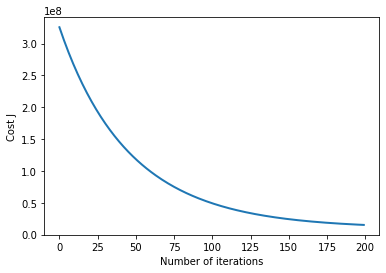

In [82]:
#['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 
#'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 
#'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 
#'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 
#'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 
#'fuelType_Petrol']
X_prediction = [1, 2019, 9573, 145, 45.6, 1.3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 
X_prediction[1:21] = (X_prediction[1:21] - mu_mercedes_features) / sigma_mercedes_features
#print(np.array(X_prediction).shape)
price = np.dot(X_prediction, theta_multi)
print(price)

pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

In [68]:
def regression_model(model):
    regressor = model
    regressor.fit(X_multi_merc, y_mercedes)
    score = regressor.score(X_multi_merc, y_mercedes)
    return regressor, score

In [90]:
#regressor, score = regression_model(LinearRegression())

y_pred = np.dot(X_multi_merc, theta_multi)
score = r2_score(y_mercedes_not_norm, y_pred)


print(score)

[-3559.50303491 28402.32789049 42804.13872468 ... 30217.63168176
 26010.26037829 38695.62678945]
0.6693308799696075


#### Error histogram

[ 5200. 34948. 49948. ... 30999. 37990. 54999.]


(array([1.1442e+04, 1.3100e+03, 1.6000e+02, 2.9000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.60503048e-02, 8.05837542e+03, 1.61166948e+04, 2.41750141e+04,
        3.22333335e+04, 4.02916529e+04, 4.83499722e+04, 5.64082916e+04,
        6.44666110e+04, 7.25249303e+04, 8.05832497e+04]),
 <BarContainer object of 10 artists>)

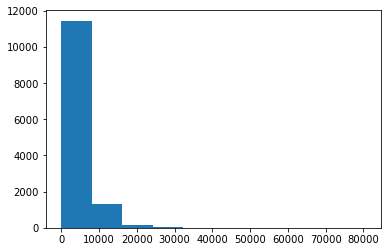

In [91]:
#error = np.abs(y_pred - y_mercedes)
#print(error)
#pyplot.hist(error)

print(y_mercedes_not_norm)
error = np.abs(y_mercedes_not_norm - y_pred)
pyplot.hist(error)

In [77]:
def normalEqn(X, y):
    """
    Computes the closed-form solution to linear regression using the normal equations.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        The value at each data point. A vector of shape (m, ).
    
    Returns
    -------
    theta : array_like
        Estimated linear regression parameters. A vector of shape (n+1, ).
    
    Instructions
    ------------
    Complete the code to compute the closed form solution to linear
    regression and put the result in theta.
    
    Hint
    ----
    Look up the function `np.linalg.pinv` for computing matrix inverse.
    """
    theta = np.zeros(X.shape[1])
    
    # ===================== YOUR CODE HERE ============================
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    # =================================================================
    return theta

In [79]:
# Calculate the parameters from the normal equation
theta = normalEqn(X_multi_not_norm, mercedes_expanded_numpy[:,1]);

# Display normal equation's result
print(theta);

# Estimate the price of a 1650 sq-ft, 3 br house
# ====================== YOUR CODE HERE ======================

#['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 
#'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 
#'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 
#'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 
#'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 
#'fuelType_Petrol']

X_prediction = [1, 2019, 9573, 145, 45.6, 1.3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 
#X_prediction[1:21] = (X_prediction[1:21] - mu_mercedes_features) / sigma_mercedes_features
price = np.dot(X_prediction, theta) # You should change this

# ============================================================

print(price)

[-3.55339445e+06  1.77941186e+03 -1.27684107e-01 -7.05802607e+00
 -1.61226057e+02  5.69979828e+03 -1.33640130e+03 -3.13626629e+03
  1.75244068e+03 -2.03047362e+03  4.78378573e+03  8.97940409e+03
  1.04959230e+04  9.04421473e+03  1.65176930e+03  1.35389300e+03
  5.57469664e+03 -1.96146928e+03  9.29681907e+01 -1.19063327e+04
 -1.17487145e+04]
22165.202993260697
